# Import

In [1]:
import torchvision
import json
import os
import shutil
from google.colab.patches import cv2_imshow
import numpy as np
import math
import pickle
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
EPOCHS = 10
DEVICE = 'cuda' # 'cpu'
EXP_NO = 25
LR = 3e-4
MAX_LR = 1e-3
LOSS_WEIGHTS = [0.9, 0.1] # [0.2, 0.8] [0.5, 0.5]
BASE_DIR = f'/content/drive/MyDrive/New Exps/SamplesH/{EXP_NO}/'

MODEL_NAME = 'convnext_base'

DATASET = 'StandfordCars' # cifar100, INaturalist, Places365, ImageNet, StandfordCars
AUGMENTATION = False # False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

os.makedirs(os.path.dirname(BASE_DIR), exist_ok=True)

In [4]:
EXPERIMENT_DICTIONARY = {
    'EPOCHS': EPOCHS,
    'DEVICE': DEVICE,
    'EXP_NO': EXP_NO,
    'MODEL': MODEL_NAME,
    'LR': LR,
    'MAX_LR': MAX_LR,
    'LOSS_WEIGHTS': LOSS_WEIGHTS,
    'DATASET': DATASET,
    'AUGMENTATION': AUGMENTATION
}

with open(BASE_DIR + "exp_info.json", "w") as outfile:
    json.dump(EXPERIMENT_DICTIONARY, outfile)

In [5]:
if MODEL_NAME == 'mobilenet_v3_small':
  MODEL = torchvision.models.mobilenet_v3_small
elif MODEL_NAME == 'mobilenet_v3_large':
  MODEL = torchvision.models.mobilenet_v3_large
elif MODEL_NAME == 'resnet18':
  MODEL = torchvision.models.resnet18
elif MODEL_NAME == 'resnet50':
  MODEL = torchvision.models.resnet50
elif MODEL_NAME == 'swin_b':
  MODEL = torchvision.models.swin_s
elif MODEL_NAME == 'vgg16':
  MODEL = torchvision.models.vgg16
elif MODEL_NAME == 'vgg19':
  MODEL = torchvision.models.vgg19
elif MODEL_NAME == 'densenet121':
  MODEL = torchvision.models.densenet121
elif MODEL_NAME == 'vit_b_16':
  MODEL = torchvision.models.vit_b_16
elif MODEL_NAME == 'efficientnet_b0':
  MODEL = torchvision.models.efficientnet_b0
elif MODEL_NAME == 'maxvit_t':
  MODEL = torchvision.models.maxvit_t
elif MODEL_NAME == 'convnext_base':
  MODEL = torchvision.models.convnext_base

# Dataset

In [6]:
transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize to 224x224 to match MobileNet's input size
    torchvision.transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    # torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((28, 28)),  # Resize to 224x224 to match MobileNet's input size
    torchvision.transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    # torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
   #  torchvision.transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),  # CIFAR-100 normalization values
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
# os.mkdir('/content/dataset/')
# os.mkdir('/content/dataset/train/')
# os.mkdir('/content/dataset/test/')

if not AUGMENTATION:
  train_transforms = test_transforms

if DATASET == 'cifar100':
  # train parameter ???
  train_dataset = torchvision.datasets.CIFAR100(root='/content/dataset/train/', download=True, transform=train_transforms)
  test_dataset = torchvision.datasets.CIFAR100(root='/content/dataset/test/', download=True, transform=test_transforms)

  NUM_CLASSES = 100
  NUM_SUPERCLASSES = 20
  NUM_SUBCLASSES = 100
elif DATASET == 'INaturalist':
  train_dataset = torchvision.datasets.INaturalist(root='/content/dataset/train/', download=True, transform=train_transforms)
  test_dataset = torchvision.datasets.INaturalist(root='/content/dataset/test/', download=True, transform=test_transforms)
elif DATASET == 'Places365':
  train_dataset = torchvision.datasets.Places365(root='/content/dataset/train/', download=True, transform=train_transforms)
  test_dataset = torchvision.datasets.Places365(root='/content/dataset/test/', download=True, transform=test_transforms)
elif DATASET == 'ImageNet': # ImageNet
  train_dataset = torchvision.datasets.ImageNet(root='/content/dataset/train/', download=True, transform=train_transforms)
  test_dataset = torchvision.datasets.ImageNet(root='/content/dataset/test/', download=True, transform=test_transforms)
else: # Standford Cars
  !unzip /content/drive/MyDrive/New\ Exps/Dataset/standford_cars.zip -d '/content/dataset/'
  shutil.copy("/content/drive/MyDrive/New Exps/Dataset/cardatasettrain.csv", "/content/dataset/cardatasettrain.csv")
  shutil.copy("/content/drive/MyDrive/New Exps/Dataset/cardatasettest.csv", "/content/dataset/cardatasettest.csv")

  NUM_CLASSES = 196
  NUM_SUPERCLASSES = 49
  NUM_SUBCLASSES = 196

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/cars_train/cars_train/03145.jpg  
  inflating: /content/dataset/cars_train/cars_train/03146.jpg  
  inflating: /content/dataset/cars_train/cars_train/03147.jpg  
  inflating: /content/dataset/cars_train/cars_train/03148.jpg  
  inflating: /content/dataset/cars_train/cars_train/03149.jpg  
  inflating: /content/dataset/cars_train/cars_train/03150.jpg  
  inflating: /content/dataset/cars_train/cars_train/03151.jpg  
  inflating: /content/dataset/cars_train/cars_train/03152.jpg  
  inflating: /content/dataset/cars_train/cars_train/03153.jpg  
  inflating: /content/dataset/cars_train/cars_train/03154.jpg  
  inflating: /content/dataset/cars_train/cars_train/03155.jpg  
  inflating: /content/dataset/cars_train/cars_train/03156.jpg  
  inflating: /content/dataset/cars_train/cars_train/03157.jpg  
  inflating: /content/dataset/cars_train/cars_train/03158.jpg  
  inflating: /content/dataset/cars_train/cars_train/0

In [8]:
#@title CIFAR100 Classes & Superclasses

if DATASET == 'cifar100':

  # Define the classes and superclasses
  cifar100_classes = [
      # Superclass: Aquatic Mammals
      {"class": "beaver", "superclass": "aquatic mammals"},
      {"class": "dolphin", "superclass": "aquatic mammals"},
      {"class": "otter", "superclass": "aquatic mammals"},
      {"class": "seal", "superclass": "aquatic mammals"},
      {"class": "whale", "superclass": "aquatic mammals"},

      # Superclass: Fish
      {"class": "aquarium fish", "superclass": "fish"},
      {"class": "flatfish", "superclass": "fish"},
      {"class": "ray", "superclass": "fish"},
      {"class": "shark", "superclass": "fish"},
      {"class": "trout", "superclass": "fish"},

      # Superclass: Flowers
      {"class": "orchid", "superclass": "flowers"},
      {"class": "poppy", "superclass": "flowers"},
      {"class": "rose", "superclass": "flowers"},
      {"class": "sunflower", "superclass": "flowers"},
      {"class": "tulip", "superclass": "flowers"},

      # Superclass: Food Containers
      {"class": "bottle", "superclass": "food containers"},
      {"class": "bowl", "superclass": "food containers"},
      {"class": "can", "superclass": "food containers"},
      {"class": "cup", "superclass": "food containers"},
      {"class": "plate", "superclass": "food containers"},

      # Superclass: Fruits and Vegetables
      {"class": "apple", "superclass": "fruits and vegetables"},
      {"class": "mushroom", "superclass": "fruits and vegetables"},
      {"class": "orange", "superclass": "fruits and vegetables"},
      {"class": "pear", "superclass": "fruits and vegetables"},
      {"class": "sweet pepper", "superclass": "fruits and vegetables"},

      # Superclass: Household Electrical Devices
      {"class": "clock", "superclass": "household electrical devices"},
      {"class": "keyboard", "superclass": "household electrical devices"},
      {"class": "lamp", "superclass": "household electrical devices"},
      {"class": "telephone", "superclass": "household electrical devices"},
      {"class": "television", "superclass": "household electrical devices"},

      # Superclass: Household Furniture
      {"class": "bed", "superclass": "household furniture"},
      {"class": "chair", "superclass": "household furniture"},
      {"class": "couch", "superclass": "household furniture"},
      {"class": "table", "superclass": "household furniture"},
      {"class": "wardrobe", "superclass": "household furniture"},

      # Superclass: Insects
      {"class": "bee", "superclass": "insects"},
      {"class": "beetle", "superclass": "insects"},
      {"class": "butterfly", "superclass": "insects"},
      {"class": "caterpillar", "superclass": "insects"},
      {"class": "cockroach", "superclass": "insects"},

      # Superclass: Large Carnivores
      {"class": "bear", "superclass": "large carnivores"},
      {"class": "leopard", "superclass": "large carnivores"},
      {"class": "lion", "superclass": "large carnivores"},
      {"class": "tiger", "superclass": "large carnivores"},
      {"class": "wolf", "superclass": "large carnivores"},

      # Superclass: Large Man-made Outdoor Things
      {"class": "bridge", "superclass": "large man-made outdoor things"},
      {"class": "castle", "superclass": "large man-made outdoor things"},
      {"class": "house", "superclass": "large man-made outdoor things"},
      {"class": "road", "superclass": "large man-made outdoor things"},
      {"class": "skyscraper", "superclass": "large man-made outdoor things"},

      # Superclass: Large Natural Outdoor Scenes
      {"class": "cloud", "superclass": "large natural outdoor scenes"},
      {"class": "forest", "superclass": "large natural outdoor scenes"},
      {"class": "mountain", "superclass": "large natural outdoor scenes"},
      {"class": "plain", "superclass": "large natural outdoor scenes"},
      {"class": "sea", "superclass": "large natural outdoor scenes"},

      # Superclass: Large Omnivores and Herbivores
      {"class": "camel", "superclass": "large omnivores and herbivores"},
      {"class": "cattle", "superclass": "large omnivores and herbivores"},
      {"class": "chimpanzee", "superclass": "large omnivores and herbivores"},
      {"class": "elephant", "superclass": "large omnivores and herbivores"},
      {"class": "kangaroo", "superclass": "large omnivores and herbivores"},

      # Superclass: Medium-sized Mammals
      {"class": "fox", "superclass": "medium-sized mammals"},
      {"class": "porcupine", "superclass": "medium-sized mammals"},
      {"class": "possum", "superclass": "medium-sized mammals"},
      {"class": "raccoon", "superclass": "medium-sized mammals"},
      {"class": "skunk", "superclass": "medium-sized mammals"},

      # Superclass: Non-insect Invertebrates
      {"class": "crab", "superclass": "non-insect invertebrates"},
      {"class": "lobster", "superclass": "non-insect invertebrates"},
      {"class": "snail", "superclass": "non-insect invertebrates"},
      {"class": "spider", "superclass": "non-insect invertebrates"},
      {"class": "worm", "superclass": "non-insect invertebrates"},

      # Superclass: People
      {"class": "baby", "superclass": "people"},
      {"class": "boy", "superclass": "people"},
      {"class": "girl", "superclass": "people"},
      {"class": "man", "superclass": "people"},
      {"class": "woman", "superclass": "people"},

      # Superclass: Reptiles
      {"class": "crocodile", "superclass": "reptiles"},
      {"class": "dinosaur", "superclass": "reptiles"},
      {"class": "lizard", "superclass": "reptiles"},
      {"class": "snake", "superclass": "reptiles"},
      {"class": "turtle", "superclass": "reptiles"},

      # Superclass: Small Mammals
      {"class": "hamster", "superclass": "small mammals"},
      {"class": "mouse", "superclass": "small mammals"},
      {"class": "rabbit", "superclass": "small mammals"},
      {"class": "shrew", "superclass": "small mammals"},
      {"class": "squirrel", "superclass": "small mammals"},

      # Superclass: Trees
      {"class": "maple tree", "superclass": "trees"},
      {"class": "oak tree", "superclass": "trees"},
      {"class": "palm tree", "superclass": "trees"},
      {"class": "pine tree", "superclass": "trees"},
      {"class": "willow tree", "superclass": "trees"},

      # Superclass: Vehicles 1
      {"class": "bicycle", "superclass": "vehicles 1"},
      {"class": "bus", "superclass": "vehicles 1"},
      {"class": "motorcycle", "superclass": "vehicles 1"},
      {"class": "pickup truck", "superclass": "vehicles 1"},
      {"class": "train", "superclass": "vehicles 1"},

      # Superclass: Vehicles 2
      {"class": "lawn mower", "superclass": "vehicles 2"},
      {"class": "rocket", "superclass": "vehicles 2"},
      {"class": "streetcar", "superclass": "vehicles 2"},
      {"class": "tank", "superclass": "vehicles 2"},
      {"class": "tractor", "superclass": "vehicles 2"},
  ]

  # Write to JSON file
  with open('cifar100_classes.json', 'w') as json_file:
      json.dump(cifar100_classes, json_file, indent=4)

  superclasses = [
      "aquatic mammals",          # 1-5
      "fish",                     # 6-10
      "flowers",                  # 11-15
      "food containers",          # 16-20
      "fruits and vegetables",    # 21-25
      "household electrical devices",  # 26-30
      "household furniture",      # 31-35
      "insects",                  # 36-40
      "large carnivores",         # 41-45
      "large man-made outdoor things", # 46-50
      "large natural outdoor scenes",  # 51-55
      "large omnivores and herbivores",# 56-60
      "medium-sized mammals",     # 61-65
      "non-insect invertebrates", # 66-70
      "people",                   # 71-75
      "reptiles",                 # 76-80
      "small mammals",            # 81-85
      "trees",                    # 86-90
      "vehicles 1",               # 91-95
      "vehicles 2"                # 96-100
  ]

  classes = [
      # Aquatic Mammals
      "beaver", "dolphin", "otter", "seal", "whale",

      # Fish
      "aquarium fish", "flatfish", "ray", "shark", "trout",

      # Flowers
      "orchid", "poppy", "rose", "sunflower", "tulip",

      # Food Containers
      "bottle", "bowl", "can", "cup", "plate",

      # Fruits and Vegetables
      "apple", "mushroom", "orange", "pear", "sweet pepper",

      # Household Electrical Devices
      "clock", "keyboard", "lamp", "telephone", "television",

      # Household Furniture
      "bed", "chair", "couch", "table", "wardrobe",

      # Insects
      "bee", "beetle", "butterfly", "caterpillar", "cockroach",

      # Large Carnivores
      "bear", "leopard", "lion", "tiger", "wolf",

      # Large Man-made Outdoor Things
      "bridge", "castle", "house", "road", "skyscraper",

      # Large Natural Outdoor Scenes
      "cloud", "forest", "mountain", "plain", "sea",

      # Large Omnivores and Herbivores
      "camel", "cattle", "chimpanzee", "elephant", "kangaroo",

      # Medium-sized Mammals
      "fox", "porcupine", "possum", "raccoon", "skunk",

      # Non-insect Invertebrates
      "crab", "lobster", "snail", "spider", "worm",

      # People
      "baby", "boy", "girl", "man", "woman",

      # Reptiles
      "crocodile", "dinosaur", "lizard", "snake", "turtle",

      # Small Mammals
      "hamster", "mouse", "rabbit", "shrew", "squirrel",

      # Trees
      "maple tree", "oak tree", "palm tree", "pine tree", "willow tree",

      # Vehicles 1
      "bicycle", "bus", "motorcycle", "pickup truck", "train",

      # Vehicles 2
      "lawn mower", "rocket", "streetcar", "tank", "tractor"
  ]

In [9]:
if DATASET == 'cifar100':

  file_path = '/content/dataset/test/cifar-100-python/meta'

  # Unpickle the file
  with open(file_path, 'rb') as file:
      data = pickle.load(file)

  alphabetical_to_original_label = {}

  for label_id, label in enumerate(data['fine_label_names']):
    label = label.replace('_', ' ')
    new_index = classes.index(label)
    superclass = cifar100_classes[new_index]['superclass']
    new_superclass_index = superclasses.index(superclass)
    # print(label, new_index, new_superclass_index)
    alphabetical_to_original_label[label_id] = {'index': new_index, 'class':classes[new_index], 'super_index':new_superclass_index, 'superclass': superclass}

  print(alphabetical_to_original_label)

  superclass_and_class_to_hierarchic_label = {}

  for key in alphabetical_to_original_label:
    info = alphabetical_to_original_label[key]
    superclass = info['superclass']
    if superclass not in superclass_and_class_to_hierarchic_label:
      hierarchic_label = 0
      superclass_and_class_to_hierarchic_label[superclass] = 0
    else:
      hierarchic_label = superclass_and_class_to_hierarchic_label[superclass] + 1
      superclass_and_class_to_hierarchic_label[superclass] = hierarchic_label
    info['hierarchic_index'] = hierarchic_label
    alphabetical_to_original_label[key] = info

  print(alphabetical_to_original_label)

In [10]:
if DATASET == 'cifar100':
  for td_id, td in enumerate(train_dataset):
    pil_img = td[0]
    numpy_img = np.clip(pil_img.permute(1, 2, 0).numpy()[:, :, ::-1] * 255, 0, 255)
    class_label = td[1]
    print(numpy_img.shape)
    # cv2_imshow(numpy_img)
    # print(alphabetical_to_original_label[class_label]['class'], alphabetical_to_original_label[class_label]['superclass'])
    if td_id % 10 == 9:
      break

In [11]:
if DATASET == 'cifar100':
  train_size = int(0.8 * len(train_dataset))
  val_size = len(train_dataset) - train_size

  # Split the dataset into training and validation
  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

  # Create data loaders for each
  train_loader_classic  = DataLoader(train_dataset, batch_size=64, shuffle=True)
  val_loader_clasic = DataLoader(val_dataset, batch_size=64, shuffle=False)
  test_loader_clasic = DataLoader(test_dataset, batch_size=64, shuffle=False)

# INaturalist Classes and Superclasses

In [12]:
if DATASET == 'INaturalist':
  pass

# Places365

In [13]:
if DATASET == 'Places365':
  pass

# Standford Cars

In [14]:
from torch.utils.data import Dataset
from PIL import Image
from scipy.io import loadmat
import pandas as pd

class StandfordCarsDataset(Dataset):
    def __init__(self, root, split, transform=None, target_transform=None):
        """
        Args:
            data (any format): The data (e.g., list of file paths, array of images).
            labels (any format): The labels associated with the data.
            transform (callable, optional): Optional transform to apply to a sample.
        """
        self.root = root
        self.split = split
        if self.split == 'train' or self.split == 'val':
          self.path = 'cars_train'
        else:
          self.path = 'cars_train'

        self.image_paths = self.root + '/' + self.path + '/' + self.path + '/'
        self.label_path = self.root + '/cars_annos.mat'
        annotation_path = '/content/dataset/cardatasettrain.csv' # if self.split == 'train' else '/content/dataset/cardatasettest.csv'
        self.annotation_df = pd.read_csv(annotation_path)
        self.data = []
        self.labels = []
        self.classes = []
        self.alphabetical_to_original_label = {}
        self.load_data()
        self.transform = transform
        self.target_transform = target_transform

    def load_data(self):
      data = loadmat(self.label_path)
      self.classes = data['class_names'][0]
      self.hierarchic_classes = list(set([cls[0].split(' ')[0] for cls in self.classes]))
      # no_samples = 8144 if self.split =='train' else 8041 # len(data['annotations'][0])
      no_samples = len(self.annotation_df)
      # for ids, sample in enumerate(data['annotations'][0]):
      for ids, sample in self.annotation_df.iterrows():
        # if (self.split == 'train' and ids < no_samples * 0.7) or (self.split == 'val' and (ids >= no_samples * 0.7 and ids < no_samples * 0.9)) or (self.split == 'test' and ids >= no_samples * 0.9):
        image_name =  sample['image']  # sample[0][0].split('/')[-1]
        image_no = int(image_name.split('.')[0])
        # if (self.split == 'train' and image_no < no_samples) or (self.split == 'val' and image_no > 8144 and image_no < 8144 + no_samples *0.8) or (self.split == 'test' and image_no > 8144 and image_no >= 8144 + no_samples *0.8):
        #  if self.split in ['val', 'test']:
        if (self.split == 'train' and ids <= no_samples * 0.7) or (self.split == 'val' and ids > no_samples * 0.7 and ids < no_samples * 0.8) or (self.split == 'test' and ids >= no_samples * 0.8):
            image_name = str(image_no).zfill(5) + '.jpg'
            self.data.append(self.image_paths + image_name)
            class_id = sample['Class'] - 1 # sample[5][0][0] - 1
            if class_id not in self.alphabetical_to_original_label:
              superclass = self.classes[class_id][0].split(' ')[0]
              self.alphabetical_to_original_label[class_id] = {'index': class_id, 'class': self.classes[class_id], 'super_index': self.hierarchic_classes.index(superclass), 'superclass':superclass}
            self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load the sample data and label
        sample = Image.open(self.data[idx]).convert("RGB") # torchvision.io.read_image(self.data[idx])
        label = self.labels[idx]

        # Apply any transformation if provided
        if self.transform:
            sample = self.transform(sample)

        if self.target_transform:
          label = self.target_transform(label)

        return sample, label

if DATASET == 'StandfordCars':
    train_dataset = StandfordCarsDataset(root='/content/dataset', split='train', transform=train_transforms)
    alphabetical_to_original_label = train_dataset.alphabetical_to_original_label
    val_dataset = StandfordCarsDataset(root='/content/dataset', split='val', transform=test_transforms)
    test_dataset = StandfordCarsDataset(root='/content/dataset', split='test', transform=test_transforms)
    train_loader_classic  = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader_clasic = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader_clasic = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model

In [19]:
#@title Flat MobileNetv3

class ClassicMobileNetV3(nn.Module):
    def __init__(self, num_classes=100, pretrained=True, dropout_p=0.5):
        super(ClassicMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)
        # print(self.mobilenet)

        if 'mobilenet_v3' in MODEL_NAME:

          # Modify the first convolutional layer to accept (28, 28) input size
          # self.mobilenet.features[0][0] = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)

          # Extract the number of features from the original classifier
          in_features = self.mobilenet.classifier[-1].in_features

          # Replace the classifier with a new sequence including Dropout
          self.mobilenet.classifier[-1] = nn.Sequential(
              # nn.Dropout(p=dropout_p),  # Dropout layer with probability p
              nn.Linear(in_features, num_classes)  # Final fully connected layer
          )

        elif 'resnet' in MODEL_NAME:
          in_features = self.mobilenet.fc.in_features
          self.mobilenet.fc = nn.Linear(in_features, num_classes)
        elif 'swin' in MODEL_NAME:
          self.mobilenet.head = nn.Linear(self.mobilenet.head.in_features, num_classes)
        elif 'vit_b_16' in MODEL_NAME:
          self.mobilenet.heads.head = nn.Linear(self.mobilenet.heads.head.in_features, num_classes)
        elif 'vgg' in MODEL_NAME:
          # ? Redundant path
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Linear(in_features, num_classes)
        elif 'densenet' in MODEL_NAME:
          in_features = self.mobilenet.classifier.in_features
          self.mobilenet.classifier = nn.Linear(in_features, num_classes)
        elif 'efficientnet' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Linear(in_features, num_classes)
        elif 'maxvit' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Linear(in_features, num_classes)
        elif 'convnext' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Linear(in_features, num_classes)
        else:
          assert False


    def forward(self, x):
        return self.mobilenet(x)

classic_model = ClassicMobileNetV3(num_classes=NUM_CLASSES, pretrained=True)

In [20]:
#@title Local Classifier at each hierarchic granularity

class HierarchicMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses = [5 for _ in range(20)], pretrained=True, device="cuda"):

      super(HierarchicMobileNetV3, self).__init__()

      self.num_superclasses = num_superclasses
      self.num_subclasses = num_subclasses

      self.superclass_clasifier = ClassicMobileNetV3(num_superclasses, pretrained)

      # self.class_classifiers = [ClassicMobileNetV3(num_subclasses[i], pretrained) for i in range(num_superclasses)]
      self.class_classifiers = nn.ModuleList(
            [ClassicMobileNetV3(num_subclasses[i], pretrained).to(device) for i in range(num_superclasses)]
        )


    def forward(self, x):
        # Predict the superclass
        # x = x.to(next(self.parameters()).device)
        superclass_prediction = self.superclass_clasifier(x)

        # Determine the predicted superclass for each item in the batch
        chosen_superclass = torch.argmax(superclass_prediction, dim=1)

        # Prepare an empty tensor to store the subclass predictions
        batch_size = x.size(0)
        class_predictions = torch.zeros(batch_size, max(self.num_subclasses), device=x.device)

        for i in range(batch_size):
            # For each item in the batch, select the corresponding subclass classifier
            class_predictions[i] = self.class_classifiers[chosen_superclass[i]](x[i].unsqueeze(0))

        return class_predictions, superclass_prediction


In [21]:
#@title Global Classifier

class GlobalMobileNetV3(nn.Module):
  def __init__(self, num_superclasses=20, num_subclasses = 100, pretrained=True):

      self.num_superclasses = num_superclasses
      self.num_subclasses = num_subclasses

      self.mobilenet = ClassicMobileNetV3(num_superclasses + num_subclasses)

  def forward(self, x):
      return self.mobilenet(x)

In [22]:
#@title Parallel MT Hierarchical

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class ParallelMultiTaskMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses=100, pretrained=True, dropout_p=0.5):
        super(ParallelMultiTaskMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)
        # Define Dropout layer
        self.dropout = nn.Dropout(p=dropout_p)

        if 'mobilenet_v3' in MODEL_NAME:
          # Modify the first convolutional layer to accept (28, 28) input size
          # self.mobilenet.features[0][0] = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)

          # Extract the number of features from the original classifier
          in_features = self.mobilenet.classifier[-1].in_features

          # Replace the original classifier with an identity layer
          self.mobilenet.classifier[-1] = Identity()

        elif 'resnet' in MODEL_NAME:
          in_features = self.mobilenet.fc.in_features
          self.mobilenet.fc = Identity()

        elif 'swin' in MODEL_NAME:
          in_features = self.mobilenet.head.in_features
          self.mobilenet.head = Identity()

        elif 'vit_b_16' in MODEL_NAME:
          in_features = self.mobilenet.heads.head.in_features
          self.mobilenet.heads.head = Identity()

        elif 'vgg' in MODEL_NAME:
          # ? Redundant path
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        elif 'densenet' in MODEL_NAME:
          in_features = self.mobilenet.classifier.in_features
          self.mobilenet.classifier = Identity()

        elif 'efficientnet' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        elif 'maxvit' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        elif 'convnext' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        self.superclass_classifier = nn.Linear(in_features, num_superclasses)
        self.subclass_classifier = nn.Linear(in_features, num_subclasses)

    def forward(self, x):
        # Pass input through the feature extractor
        features = self.mobilenet(x)
        features = torch.flatten(features, 1)  # Flatten the output for the classifier

        # Apply Dropout to the features
        # features = self.dropout(features)

        # Compute superclass and subclass predictions
        superclass_output = self.superclass_classifier(features)
        subclass_output = self.subclass_classifier(features)

        return subclass_output, superclass_output

# parallel_model = ParallelMultiTaskMobileNetV3(num_superclasses=NUM_SUPERCLASSES, num_subclasses=NUM_SUBCLASSES, pretrained=True)

In [23]:
#@title Cascaded MT Hierarchical

class CascadedMultiTaskMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses=100, pretrained=True, dropout_p=0.5):
        super(CascadedMultiTaskMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)

        # Define Dropout layer
        self.dropout = nn.Dropout(p=dropout_p)

        # Modify the first convolutional layer to accept (28, 28) input size
        # self.mobilenet.features[0][0] = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        if 'mobilenet_v3' in MODEL_NAME:
        # Adjust the classifier input size if needed (e.g., due to smaller input size)
          in_features = self.mobilenet.classifier[-1].in_features

          # Replace the original classifier with an identity layer
          self.mobilenet.classifier[-1] = Identity()

        elif 'resnet' in MODEL_NAME:
          in_features = self.mobilenet.fc.in_features
          self.mobilenet.fc = Identity()

        elif 'swin' in MODEL_NAME:
          in_features = self.mobilenet.head.in_features
          self.mobilenet.head = Identity()

        elif 'vit_b_16' in MODEL_NAME:
          in_features = self.mobilenet.heads.head.in_features
          self.mobilenet.heads.head = Identity()

        elif 'vgg' in MODEL_NAME:
          # ? Redundant path
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        elif 'densenet' in MODEL_NAME:
          in_features = self.mobilenet.classifier.in_features
          self.mobilenet.classifier = Identity()

        elif 'efficientnet' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        elif 'maxvit' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        elif 'convnext' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = Identity()

        # Superclass classifier
        self.superclass_classifier = nn.Linear(in_features, num_superclasses)

        # Subclass classifier with additional input for superclass prediction
        self.subclass_classifier = nn.Linear(in_features + num_superclasses, num_subclasses)

    def forward(self, x):
        # Pass input through the feature extractor (all layers except the classifier)
        features = self.mobilenet(x)
        features = torch.flatten(features, 1)

        # Apply Dropout to the features
        # features = self.dropout(features)

        # Compute superclass prediction
        superclass_output = self.superclass_classifier(features)

        # Concatenate the superclass prediction with the features
        combined_input = torch.cat((features, superclass_output), dim=1)

        # Apply Dropout to the combined input before subclass classification
        # combined_input = self.dropout(combined_input)

        # Compute subclass prediction using combined input
        subclass_output = self.subclass_classifier(combined_input)

        return subclass_output, superclass_output

# cascaded_model = CascadedMultiTaskMobileNetV3(num_superclasses=NUM_SUPERCLASSES, num_subclasses=NUM_SUBCLASSES, pretrained=True)

In [24]:
# Implement Deep Supervised MT

# Extra Dataloaders

In [25]:
def get_hierarchic_labels(target):
    superclass_label = alphabetical_to_original_label[target]['super_index']
    target = alphabetical_to_original_label[target]['index']
    return superclass_label, target

# Modify the dataset to return hierarchical labels
if DATASET == 'cifar100':
  train_dataset_hierarchic = torchvision.datasets.CIFAR100(root='/content/dataset/train/', train=True, download=False, transform=train_transforms, target_transform=get_hierarchic_labels)
  train_dataset_hierarchic, val_dataset_hierarchic = random_split(train_dataset_hierarchic, [train_size, val_size])
  test_dataset_hierarchic = torchvision.datasets.CIFAR100(root='/content/dataset/test/', train=False, download=False, transform=test_transforms, target_transform=get_hierarchic_labels)
elif DATASET == 'StandfordCars':
  train_dataset_hierarchic = StandfordCarsDataset(root='/content/dataset', split='train', transform=train_transforms, target_transform=get_hierarchic_labels)
  val_dataset_hierarchic = StandfordCarsDataset(root='/content/dataset', split='val', transform=test_transforms, target_transform=get_hierarchic_labels)
  test_dataset_hierarchic = StandfordCarsDataset(root='/content/dataset', split='test', transform=test_transforms, target_transform=get_hierarchic_labels)

# DataLoader for HierarchicMobileNetV3
train_loader_hierarchic = DataLoader(train_dataset_hierarchic, batch_size=32, shuffle=True, num_workers=4)
val_loader_hierarchic = DataLoader(val_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)
test_loader_hierarchic = DataLoader(test_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)

In [26]:
def get_global_labels(target):
    superclass_label = alphabetical_to_original_label[target]['super_index']
    global_label = superclass_label * 100 + v
    return global_label

# Load and split the dataset for GlobalMobileNetV3
if DATASET == 'cifar100':
  full_global_dataset = torchvision.datasets. CIFAR100(root='/content/dataset/train/', train=True, download=False, transform=transform, target_transform=get_global_labels)
  train_dataset_global, val_dataset_global = random_split(full_global_dataset, [train_size, val_size])
  test_dataset_global = torchvision.datasets.CIFAR100(root='/content/dataset/test/', train=False, download=False, transform=transform, target_transform=get_global_labels)
elif DATASET == 'StandfordCars':
   train_dataset_global = StandfordCarsDataset(root='/content/dataset', split='train', transform=train_transforms, target_transform=get_global_labels)
   val_dataset_global = StandfordCarsDataset(root='/content/dataset', split='val', transform=test_transforms, target_transform=get_global_labels)
   test_dataset_global = StandfordCarsDataset(root='/content/dataset', split='test', transform=test_transforms, target_transform=get_global_labels)

# DataLoader for GlobalMobileNetV3
train_loader_global = DataLoader(train_dataset_global, batch_size=32, shuffle=True, num_workers=4)
val_loader_global = DataLoader(val_dataset_global, batch_size=32, shuffle=False, num_workers=4)
test_loader_global = DataLoader(test_dataset_global, batch_size=32, shuffle=False, num_workers=4)

In [27]:
# DataLoader for ParallelMultiTaskMobileNetV3 (superclass and subclass)
train_loader_parallel = DataLoader(train_dataset_hierarchic, batch_size=32, shuffle=True, num_workers=4)
val_loader_parallel = DataLoader(val_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)
test_loader_parallel = DataLoader(test_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)

In [28]:
# DataLoader for CascadedMultiTaskMobileNetV3 (superclass and subclass)
train_loader_cascaded = DataLoader(train_dataset_hierarchic, batch_size=32, shuffle=True, num_workers=4)
val_loader_cascaded = DataLoader(val_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)
test_loader_cascaded = DataLoader(test_dataset_hierarchic, batch_size=32, shuffle=False, num_workers=4)

# Training Procedures

In [29]:
import torch
import copy
from torch.optim.lr_scheduler import OneCycleLR

def train_classic_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=MAX_LR, phases=['train', 'val']):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss':[], 'test_acc':[]}

    # Calculate total steps for 1CycleLR (total number of batches in training phase)
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()  # Update the learning rate according to the 1Cycle policy

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the model if validation loss has decreased
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_path = BASE_DIR + f'classic_model_epoch_{epoch+1}.pt'
                torch.save(model.state_dict(), model_save_path)
                print(f'New best model saved with validation loss: {best_val_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [30]:
def train_hierarchic_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss':[], 'test_acc':[]}


    device2 = next(model.class_classifiers[0].mobilenet.parameters()).device
    print(f"The first classifier's MobileNetV3 model is on: {device2}")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)
                    hierarchic_labels = torch.zeros(subclass_labels.shape[0], device=device)
                    for idx, subclass_label in enumerate(subclass_labels):
                      hierarchic_label = alphabetical_to_original_label[subclass_label.item()]['hierarchic_index']
                      hierarchic_labels[idx] = hierarchic_label
                    hierarchic_labels = hierarchic_labels.long()
                    superclass_loss = criterion(superclass_outputs, superclass_labels)
                    subclass_loss = criterion(subclass_outputs, hierarchic_labels)
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum((subclass_preds == hierarchic_labels.data) * (superclass_preds == superclass_labels.data)).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [31]:
def train_hierarchic_mobilenet_fast(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss':[], 'test_acc':[]}

    # Precompute hierarchic label mapping on CPU for faster indexing
    original_to_hierarchic = torch.tensor(
        [alphabetical_to_original_label[i]['hierarchic_index'] for i in range(len(alphabetical_to_original_label))],
        dtype=torch.long, device=device
    )

    for epoch in range(num_epochs):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)

                    # Vectorized label conversion
                    hierarchic_labels = original_to_hierarchic[subclass_labels]

                    superclass_loss = criterion(superclass_outputs, superclass_labels)
                    subclass_loss = criterion(subclass_outputs, hierarchic_labels)
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum((subclass_preds == hierarchic_labels) & (superclass_preds == superclass_labels)).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            # Correct the calculation of loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [32]:
'''
def train_global_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history
'''

"\ndef train_global_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):\n    model = model.to(device)\n    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}\n\n    for epoch in range(num_epochs):\n        print(f'Epoch {epoch+1}/{num_epochs}')\n        print('-' * 10)\n\n        for phase in ['train', 'val']:\n            if phase == 'train':\n                model.train()\n            else:\n                model.eval()\n\n            running_loss = 0.0\n            running_corrects = 0\n\n            for inputs, labels in dataloaders[phase]:\n                inputs, labels = inputs.to(device), labels.to(device)\n\n                optimizer.zero_grad()\n\n                with torch.set_grad_enabled(phase == 'train'):\n                    outputs = model(inputs)\n                    loss = criterion(outputs, labels)\n                    _, preds = torch.max(outputs, 1)\n\n                    if phase == 'train':\n               

In [33]:
import torch
import copy

def train_parallel_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=MAX_LR, phases=['train', 'val']):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_acc_superclass': [], 'val_acc_superclass': [], 'test_loss':[], 'test_acc':[], 'test_acc_superclass':[]}

    # Calculate total steps for 1CycleLR (total number of batches in training phase)
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)
                    superclass_loss = criterion(superclass_outputs, superclass_labels) * LOSS_WEIGHTS[1]
                    subclass_loss = criterion(subclass_outputs, subclass_labels) * LOSS_WEIGHTS[0]
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum(subclass_preds == subclass_labels.data).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        superclass_loss.backward(retain_graph=True)
                        subclass_loss.backward()
                        optimizer.step()
                        scheduler.step()  # Update the learning rate according to the 1Cycle policy

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Superclass Acc: {epoch_acc_superclass:.4f}')

            # Save the model if validation loss has decreased
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_path = BASE_DIR + f'parallel_model_epoch_{epoch+1}.pt'
                torch.save(model.state_dict(), model_save_path)
                print(f'New best model saved with validation loss: {best_val_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [34]:
import torch
import copy

def train_cascaded_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=MAX_LR, phases=['train', 'val']):
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_acc_superclass': [], 'val_acc_superclass': [], 'test_loss':[], 'test_acc':[], 'test_acc_superclass':[]}

    # Calculate total steps for 1CycleLR (total number of batches in training phase)
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_corrects_superclass = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                superclass_labels, subclass_labels = labels
                superclass_labels = superclass_labels.to(device)
                subclass_labels = subclass_labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    subclass_outputs, superclass_outputs = model(inputs)
                    superclass_loss = criterion(superclass_outputs, superclass_labels) * LOSS_WEIGHTS[1]
                    subclass_loss = criterion(subclass_outputs, subclass_labels) * LOSS_WEIGHTS[0]
                    loss = superclass_loss + subclass_loss

                    _, superclass_preds = torch.max(superclass_outputs, 1)
                    _, subclass_preds = torch.max(subclass_outputs, 1)
                    running_corrects += torch.sum(subclass_preds == subclass_labels.data).item()
                    running_corrects_superclass += torch.sum(superclass_preds == superclass_labels.data).item()

                    if phase == 'train':
                        superclass_loss.backward(retain_graph=True)
                        subclass_loss.backward()
                        optimizer.step()
                        scheduler.step()  # Update the learning rate according to the 1Cycle policy

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_acc_superclass = running_corrects_superclass / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_acc_superclass'].append(epoch_acc_superclass)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Superclass Acc: {epoch_acc_superclass:.4f}')

            # Save the model if validation loss has decreased
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_path = BASE_DIR + f'cascaded_model_epoch_{epoch+1}.pt'
                torch.save(model.state_dict(), model_save_path)
                print(f'New best model saved with validation loss: {best_val_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

# Train

In [35]:
# Initialize the model
classic_model = ClassicMobileNetV3(num_classes=NUM_CLASSES, pretrained=True)

# Define the loss function and optimizer
optimizer = optim.Adam(classic_model.parameters(), lr=LR)

# Call the training function for ClassicMobileNetV3
trained_classic_model, classic_history = train_classic_mobilenet(
    model=classic_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
Train Loss: 4.9518 Acc: 0.0451
Val Loss: 3.9511 Acc: 0.1337
New best model saved with validation loss: 3.9511
Epoch 2/10
----------
Train Loss: 2.7460 Acc: 0.4201
Val Loss: 1.7186 Acc: 0.5767
New best model saved with validation loss: 1.7186
Epoch 3/10
----------
Train Loss: 1.0909 Acc: 0.7246
Val Loss: 0.9808 Acc: 0.7166
New best model saved with validation loss: 0.9808
Epoch 4/10
----------
Train Loss: 0.4244 Acc: 0.8911
Val Loss: 0.8881 Acc: 0.7399
New best model saved with validation loss: 0.8881
Epoch 5/10
----------
Train Loss: 0.2132 Acc: 0.9465
Val Loss: 0.7524 Acc: 0.8123
New best model saved with validation loss: 0.7524
Epoch 6/10
----------
Train Loss: 0.1142 Acc: 0.9740
Val Loss: 0.5238 Acc: 0.8650
New best model saved with validation loss: 0.5238
Epoch 7/10
----------
Train Loss: 0.0296 Acc: 0.9947
Val Loss: 0.4254 Acc: 0.8957
New best model saved with validation loss: 0.4254
Epoch 8/10
----------
Train Loss: 0.0135 Acc: 0.9982
Val Loss: 0.3918 Acc: 0

In [36]:
hierarchic_model = HierarchicMobileNetV3(num_superclasses=20, num_subclasses=[5 for _ in range(20)], pretrained=True, device=DEVICE)
optimizer = optim.Adam(hierarchic_model.parameters(), lr=LR)

'''
trained_hierarchic_model, hierarchic_history = train_hierarchic_mobilenet_fast(
    model=hierarchic_model,
    dataloaders={'train': train_loader_hierarchic, 'val': val_loader_hierarchic, 'test':test_loader_hierarchic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)
'''

"\ntrained_hierarchic_model, hierarchic_history = train_hierarchic_mobilenet_fast(\n    model=hierarchic_model,\n    dataloaders={'train': train_loader_hierarchic, 'val': val_loader_hierarchic, 'test':test_loader_hierarchic},\n    criterion=criterion,\n    optimizer=optimizer,\n    num_epochs=EPOCHS,\n    device=DEVICE  # or 'cpu' if you don't have a GPU\n)\n"

In [37]:
parallel_model = ParallelMultiTaskMobileNetV3(num_superclasses=NUM_SUPERCLASSES, num_subclasses=NUM_SUBCLASSES, pretrained=True)
optimizer = optim.Adam(parallel_model.parameters(), lr=LR)

# Call the training function for ParallelMultiTaskMobileNetV3
trained_parallel_model, parallel_history = train_parallel_mobilenet(
    model=parallel_model,
    dataloaders={'train': train_loader_parallel, 'val': val_loader_parallel, 'test':test_loader_parallel},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

Epoch 1/10
----------
Train Loss: 4.6480 Acc: 0.0675 Superclass Acc: 0.1556
Val Loss: 3.4919 Acc: 0.2233 Superclass Acc: 0.2810
New best model saved with validation loss: 3.4919
Epoch 2/10
----------
Train Loss: 2.2568 Acc: 0.4841 Superclass Acc: 0.5348
Val Loss: 1.6842 Acc: 0.5399 Superclass Acc: 0.6626
New best model saved with validation loss: 1.6842
Epoch 3/10
----------
Train Loss: 1.2907 Acc: 0.6315 Superclass Acc: 0.6881
Val Loss: 1.9976 Acc: 0.4294 Superclass Acc: 0.5939
Epoch 4/10
----------
Train Loss: 0.7764 Acc: 0.7674 Superclass Acc: 0.7878
Val Loss: 1.0349 Acc: 0.7018 Superclass Acc: 0.7644
New best model saved with validation loss: 1.0349
Epoch 5/10
----------
Train Loss: 0.2912 Acc: 0.9104 Superclass Acc: 0.9133
Val Loss: 0.6393 Acc: 0.8221 Superclass Acc: 0.8945
New best model saved with validation loss: 0.6393
Epoch 6/10
----------
Train Loss: 0.0812 Acc: 0.9814 Superclass Acc: 0.9754
Val Loss: 0.4753 Acc: 0.8613 Superclass Acc: 0.9129
New best model saved with valida

In [38]:
cascaded_model = CascadedMultiTaskMobileNetV3(num_superclasses=NUM_SUPERCLASSES, num_subclasses=NUM_SUBCLASSES, pretrained=True)
optimizer = optim.Adam(cascaded_model.parameters(), lr=LR)

trained_cascaded_model, cascaded_history = train_cascaded_mobilenet(
    model=cascaded_model,
    dataloaders={'train': train_loader_cascaded, 'val': val_loader_cascaded, 'test':test_loader_cascaded},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

Epoch 1/10
----------
Train Loss: 4.6085 Acc: 0.0712 Superclass Acc: 0.1463
Val Loss: 3.2670 Acc: 0.2479 Superclass Acc: 0.3239
New best model saved with validation loss: 3.2670
Epoch 2/10
----------
Train Loss: 2.2064 Acc: 0.4738 Superclass Acc: 0.4924
Val Loss: 2.2632 Acc: 0.4000 Superclass Acc: 0.4810
New best model saved with validation loss: 2.2632
Epoch 3/10
----------
Train Loss: 1.4003 Acc: 0.5994 Superclass Acc: 0.6348
Val Loss: 2.0565 Acc: 0.4736 Superclass Acc: 0.5313
New best model saved with validation loss: 2.0565
Epoch 4/10
----------
Train Loss: 0.9291 Acc: 0.7223 Superclass Acc: 0.7337
Val Loss: 1.0290 Acc: 0.7067 Superclass Acc: 0.7681
New best model saved with validation loss: 1.0290
Epoch 5/10
----------
Train Loss: 0.3406 Acc: 0.8969 Superclass Acc: 0.8825
Val Loss: 0.6784 Acc: 0.8123 Superclass Acc: 0.8638
New best model saved with validation loss: 0.6784
Epoch 6/10
----------
Train Loss: 0.0985 Acc: 0.9735 Superclass Acc: 0.9651
Val Loss: 0.4614 Acc: 0.8638 Super

# Plot

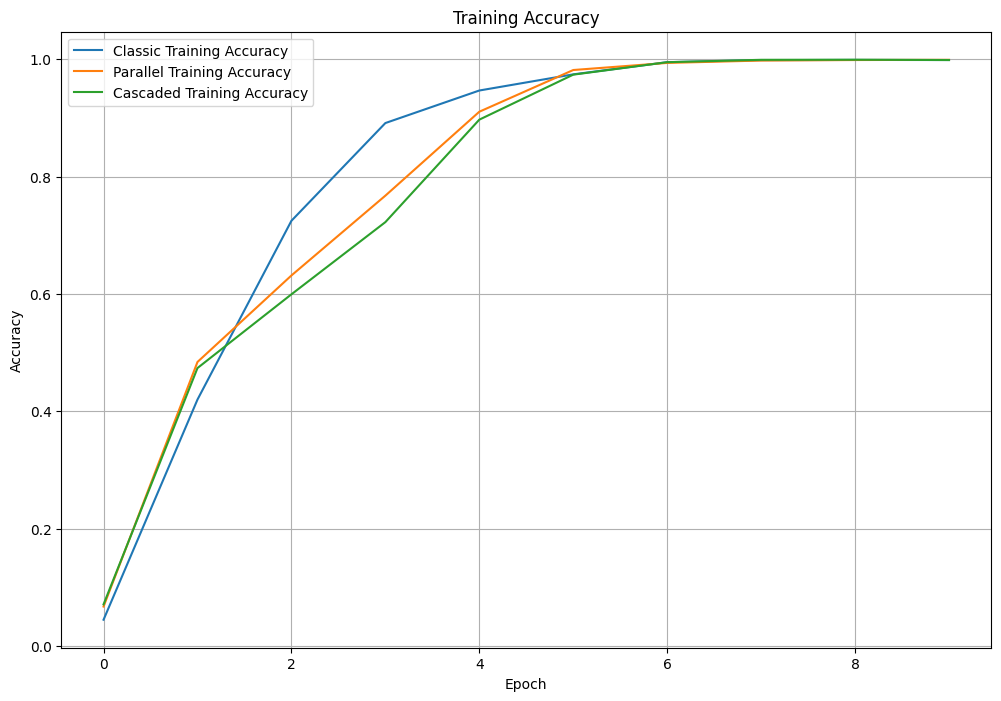

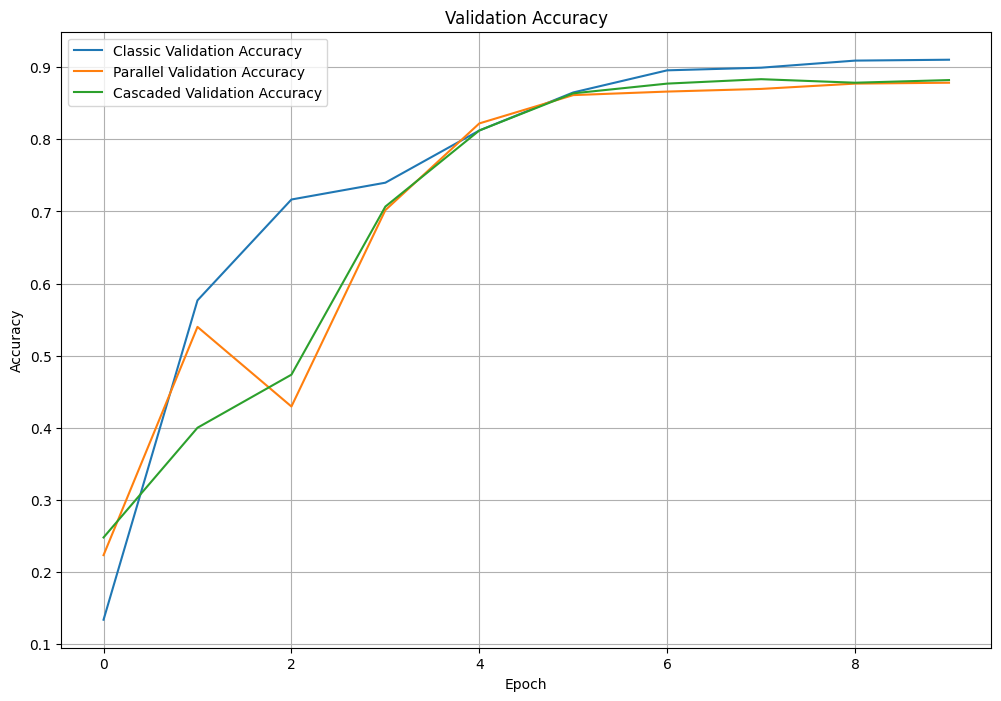

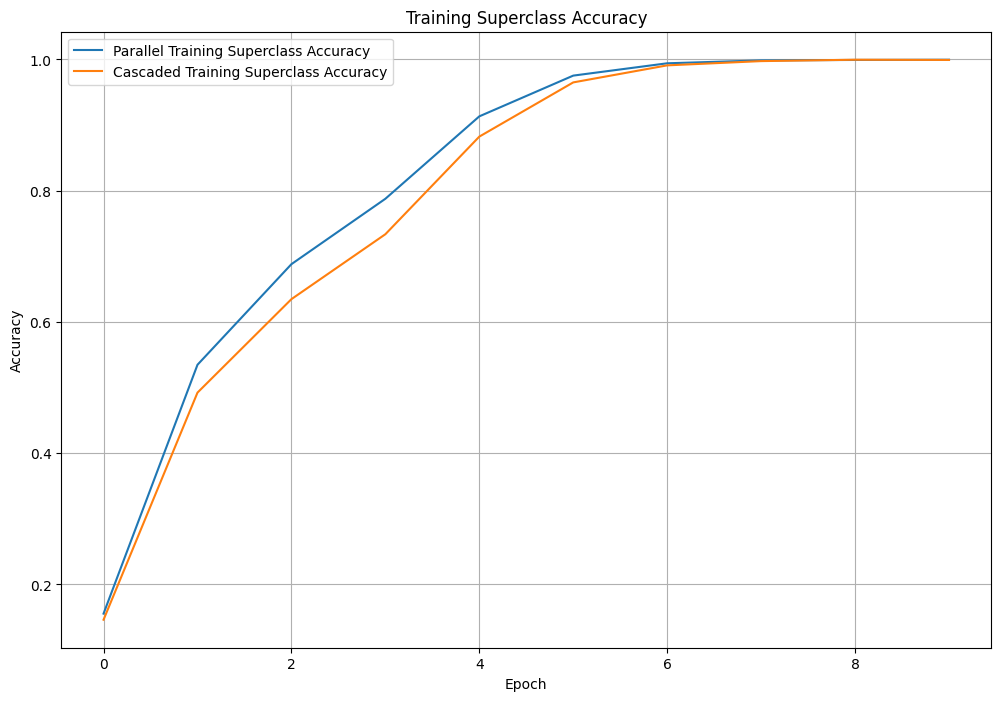

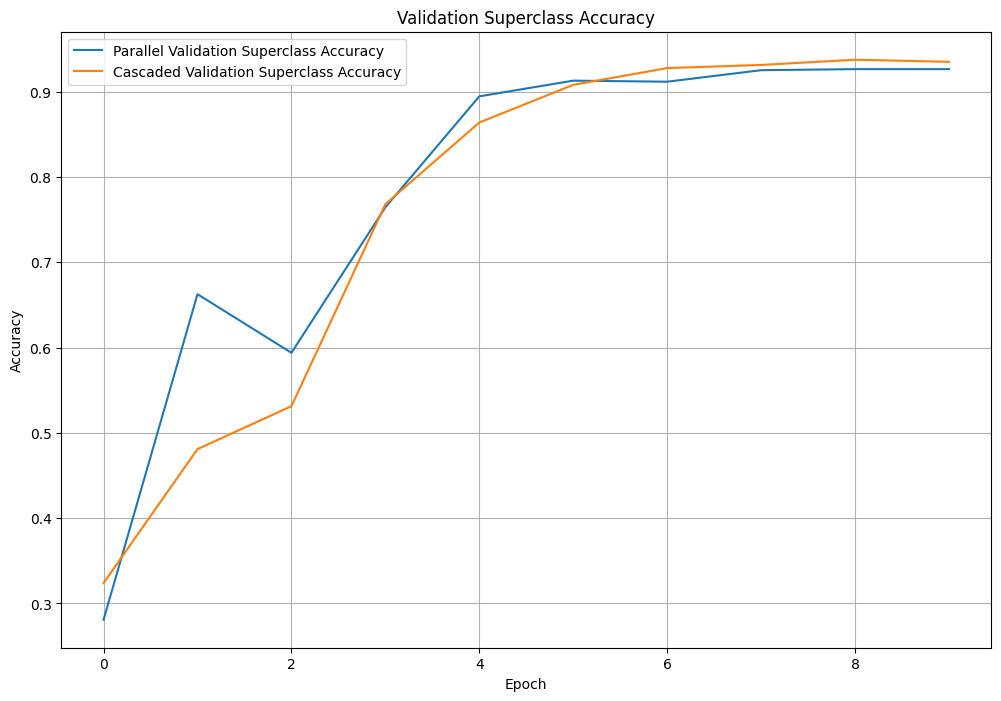

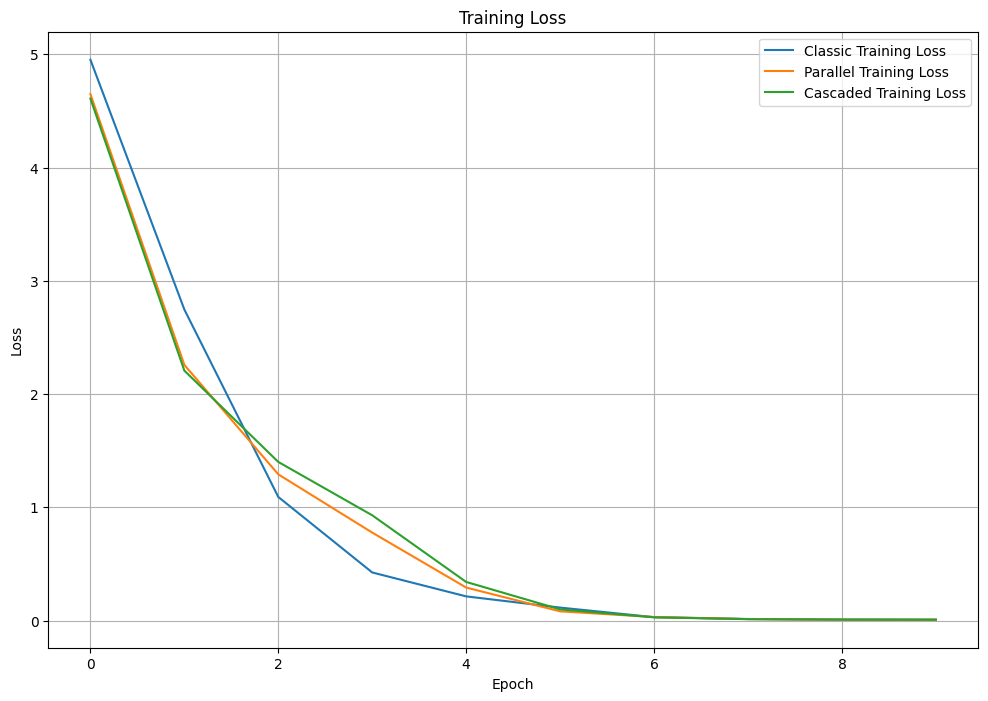

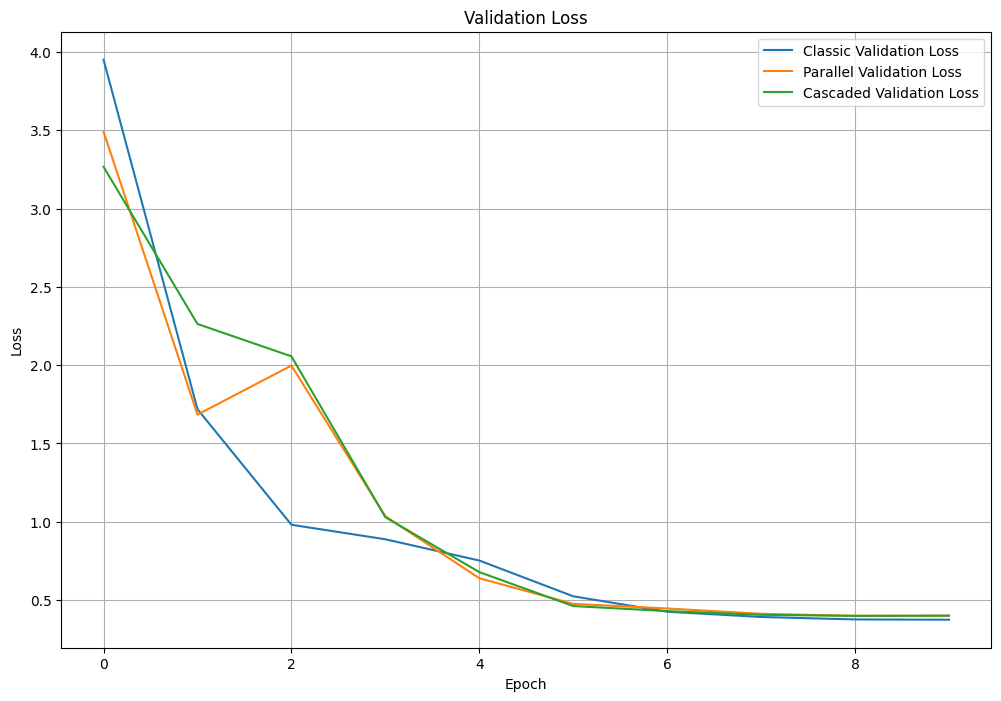

In [39]:
import os
import matplotlib.pyplot as plt

# Assuming you have these history dictionaries from your training sessions
# Each dictionary should contain lists like 'train_acc', 'val_acc', 'train_loss', 'val_loss'
# Example:
# classic_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# hierarchic_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# global_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# parallel_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}
# cascaded_history = {'train_acc': [...], 'val_acc': [...], 'train_loss': [...], 'val_loss': [...]}

# List of histories and labels for the plot
histories = [
    ('Classic', classic_history),
    # ('Hierarchic', hierarchic_history),
    ('Parallel', parallel_history),
    ('Cascaded', cascaded_history)
]

# Function to create a folder and save the plot
def save_plot(history_key, title, ylabel, save_path):
    # Create the directory if it doesn't exist

    # Plot the metric for each model
    plt.figure(figsize=(12, 8))
    for label, history in histories:
      if history_key in history:
        plt.plot(history[history_key], label=f'{label} {title}')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True)

    # Save the plot to the specified path
    plt.savefig(save_path)

    # Optionally, show the plot (you can comment this out if you don't want to display it)
    plt.show()

# Define the base directory where you want to save the plots
base_dir = BASE_DIR

# Save plots for each metric
save_plot('train_acc', 'Training Accuracy', 'Accuracy', os.path.join(base_dir, 'training_accuracy.png'))
save_plot('val_acc', 'Validation Accuracy', 'Accuracy', os.path.join(base_dir, 'validation_accuracy.png'))
save_plot('train_acc_superclass', 'Training Superclass Accuracy', 'Accuracy', os.path.join(base_dir, 'training_accuracy_superclass.png'))
save_plot('val_acc_superclass', 'Validation Superclass Accuracy', 'Accuracy', os.path.join(base_dir, 'validation_accuracy_superclass.png'))
save_plot('train_loss', 'Training Loss', 'Loss', os.path.join(base_dir, 'training_loss.png'))
save_plot('val_loss', 'Validation Loss', 'Loss', os.path.join(base_dir, 'validation_loss.png'))

# Test

In [ ]:
optimizer = optim.Adam(trained_classic_model.parameters(), lr=LR)

_, classic_history = train_classic_mobilenet(
    model=trained_classic_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    device=DEVICE,  # or 'cpu' if you don't have a GPU
    phases = ['test']
)

classic_accuracy = classic_history['test_acc']

optimizer = optim.Adam(trained_parallel_model.parameters(), lr=LR)

_, parallel_history = train_parallel_mobilenet(
    model=trained_parallel_model,
    dataloaders={'train': train_loader_parallel, 'val': val_loader_parallel, 'test':test_loader_parallel},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    device=DEVICE,  # or 'cpu' if you don't have a GPU
    phases = ['test']
)

parallel_accuracy = parallel_history['test_acc']

optimizer = optim.Adam(trained_cascaded_model.parameters(), lr=LR)

_, cascaded_history = train_cascaded_mobilenet(
    model=trained_cascaded_model,
    dataloaders={'train': train_loader_cascaded, 'val': val_loader_cascaded, 'test':test_loader_cascaded},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    device=DEVICE,  # or 'cpu' if you don't have a GPU
    phases = ['test']
)

cascaded_accuracy = cascaded_history['test_acc']

Epoch 1/1
----------
Test Loss: 0.4312 Acc: 0.8808
Epoch 1/1
----------
Test Loss: 0.4415 Acc: 0.8692 Superclass Acc: 0.9029
Epoch 1/1
----------
Test Loss: 0.4806 Acc: 0.8686 Superclass Acc: 0.9011


In [ ]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Classic Accuracy', 'Parallel Accuracy', 'Cascaded Accuracy']

values = [classic_accuracy[0], parallel_accuracy[0], cascaded_accuracy[0]]

# Create a bar plot
plt.bar(categories, values)

# Add titles and labels
plt.title('Test Accuracy')
plt.xlabel('Method')
plt.ylabel('Accuracy')

for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.savefig(os.path.join(base_dir, 'test_accuracy.png'))

plt.show()



In [ ]:
from google.colab import runtime
runtime.unassign()